In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import os
from data_analysis import InstanceResult
group_names = os.listdir("../guannan/exp_2")
data: dict[tuple[str, int], dict[tuple[str, str], InstanceResult]] = {}
white_pairs: set[tuple[str, str]] = set()  # Non- 2-branch N/A pairs
for group_name in group_names:
    log_dir = os.path.join("../guannan/exp_2", group_name, "log")
    for log_file in sorted(os.listdir(log_dir)):
        try:
            log_path = os.path.join(log_dir, log_file)
            result = InstanceResult().from_log(log_path)
            # if not result.evaluator_name.startswith("word"):
            #     continue
            if result.evaluator_name == "word-fast" and not result.invalid:
                white_pairs.add(tuple(sorted([result.verilog_1_basename, result.verilog_2_basename])))
            if result.completed and result.time_spent <= 7200.0:
                key = (result.evaluator_name, result.word_width)
                if key not in data:
                    data[key] = {}
                inner_key = tuple(sorted([result.verilog_1_basename, result.verilog_2_basename]))
                if inner_key not in data[key]:
                    data[key][inner_key] = result
                else:
                    data[key][inner_key] = InstanceResult().from_merged(data[key][inner_key], result, "virtual")
        except Exception as e:
            print(f"Failed to parse {log_file}: {e}")

    for bit in [8, 16, 32]:
        d = {}
        for source in [("word-fast", bit), ("word-even", bit)]:
            for key, result in data.get(source, {}).items():
                if key not in d:
                    d[key] = result
                else:
                    d[key] = InstanceResult().from_merged(d[key], result, "virtual")
        data[("word-union", bit)] = d

    for bit in [8, 16, 32]:
        data[("word-even-f", bit)] = {k: v for k, v in data[("word-even", bit)].items() if k in white_pairs}
        
for k, v in sorted(data.items()):
    bench_counter: dict[str, int] = {}
    for inst in v.values():
        group = inst.group_name
        bench_counter[group] = bench_counter.get(group, 0) + 1
    print(f"{k}: {len(v)} ({sorted(bench_counter.items())})")

('nuxmv', 4): 91 ([('barcode_a', 6), ('barcode_b', 5), ('counter', 11), ('diffeq', 10), ('ellipf', 14), ('gcd', 15), ('gcd_alt', 15), ('kalman', 15)])
('nuxmv', 5): 52 ([('barcode_a', 6), ('barcode_b', 5), ('counter', 1), ('diffeq', 3), ('ellipf', 13), ('gcd', 10), ('gcd_alt', 8), ('kalman', 6)])
('nuxmv', 6): 25 ([('barcode_a', 6), ('barcode_b', 3), ('counter', 1), ('ellipf', 13), ('gcd', 1), ('gcd_alt', 1)])
('nuxmv', 7): 20 ([('barcode_a', 6), ('barcode_b', 1), ('ellipf', 13)])
('nuxmv', 8): 18 ([('barcode_a', 6), ('barcode_b', 1), ('ellipf', 11)])
('nuxmv', 16): 15 ([('barcode_a', 6), ('barcode_b', 1), ('ellipf', 8)])
('nuxmv', 32): 11 ([('barcode_a', 5), ('ellipf', 6)])
('word-even', 8): 49 ([('barcode_a', 6), ('barcode_b', 3), ('counter', 15), ('diffeq', 4), ('ellipf', 10), ('gcd', 7), ('gcd_alt', 2), ('kalman', 2)])
('word-even', 16): 40 ([('barcode_a', 6), ('barcode_b', 3), ('counter', 14), ('ellipf', 10), ('gcd', 6), ('gcd_alt', 1)])
('word-even', 32): 33 ([('barcode_a', 6), (

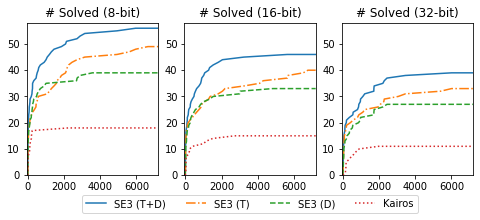

In [29]:
def get_finish_times(method: str, width: int) -> list[float]:
    return sorted(v.time_spent for v in data[(method, width)].values())

def plot_finish_times(values: list[float], style: str, ax: plt.Axes):
    x = [0.0] + values + [7200.0]
    y = [i for i in range(len(x)-1)] + [len(x)-2]
    # x = np.log(np.array(x[1:]))
    # y = np.array(y[1:])
    ax.set_xlim(-50, 7200)
    ax.set_ylim(0, 58)
    ax.plot(x, y, style)
    # ax.legend()
    

fig, ax = plt.subplots(1, 3, figsize=(8, 2.8))

for i, bit in enumerate([8, 16, 32]):
    plot_finish_times(get_finish_times("word-union", bit), "-", ax[i])
    plot_finish_times(get_finish_times("word-even", bit), "-.", ax[i])
    plot_finish_times(get_finish_times("word-fast", bit), "--", ax[i])
    # plot_finish_times(get_finish_times("word-even-f", bit), ":", ax[i], "SE3 (S on A)")
    plot_finish_times(get_finish_times("nuxmv", bit), ":", ax[i])
    # ax[i].set_xticklabels(["", "0", "1000", "2000", "    3000 (sec)"], fontsize=10)

ax[0].set_title("# Solved (8-bit)")
ax[1].set_title("# Solved (16-bit)")
ax[2].set_title("# Solved (32-bit)")
ax[1].legend(["SE3 (T+D)", "SE3 (T)", "SE3 (D)", "Kairos"], fontsize=10, loc="lower center", bbox_to_anchor=(0.5, -0.28), ncol=4)

fig.savefig("finish_times.pdf", bbox_inches="tight")

In [9]:
common_cases: set[tuple[str, str]] = None
for a in ["word-fast", "word-even"]:
    for b in [8, 16, 32]:
        k = data[(a, b)].keys()
        common_cases = k if common_cases is None else common_cases & k
print(f"Common cases: {sorted(common_cases)}")

Common cases: [('barcode_1', 'barcode_1_1'), ('barcode_1', 'barcode_2'), ('barcode_1_1', 'barcode_2'), ('barcode_1_1', 'barcode_2_2'), ('barcode_2', 'barcode_2_2'), ('barcode_2b', 'barcode_3'), ('barcode_2b', 'barcode_4'), ('barcode_3', 'barcode_4'), ('counter_1', 'counter_1_1'), ('counter_1', 'counter_2'), ('counter_1', 'counter_3_2'), ('counter_1_1', 'counter_3_2'), ('counter_2', 'counter_3'), ('counter_2', 'counter_4'), ('counter_3', 'counter_4'), ('ellipf_1_2', 'ellipf_1_2_1'), ('ellipf_1_2', 'ellipf_2_3'), ('ellipf_1_2', 'ellipf_2_3_2'), ('ellipf_2_3', 'ellipf_2_3_2'), ('gcd_2', 'gcd_3b'), ('gcd_alt_1', 'gcd_alt_2')]


/tmp/ipykernel_3650/4028973944.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0, 10, 20], fontsize=10)
/tmp/ipykernel_3650/4028973944.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f"$10^{{{v}}}$" for v in range(5)], fontsize=10)
/tmp/ipykernel_3650/4028973944.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels([f"$10^{{{v}}}$" for v in range(4)], fontsize=10)


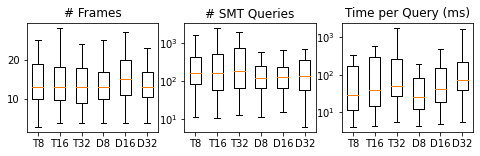

In [31]:
frame_values = []
query_values = []
query_per_values = []
for a in ["word-even", "word-fast"]:
    for b in [8, 16, 32]:
        frame_values.append(sorted(v.frame_count for v in data[(a, b)].values()))
        query_values.append(sorted(v.sat_query_count for k, v in data[(a, b)].items() if k in common_cases))
        query_per_values.append(sorted(v.time_spent / v.sat_query_count for k, v in data[(a, b)].items() if k in common_cases))

fig, ax = plt.subplots(1, 3, figsize=(8, 2))
labels = ["T8", "T16", "T32", "D8", "D16", "D32"]
_ = ax[0].boxplot(frame_values, labels=labels)
ax[0].set_title("# Frames")
ax[0].set_yticklabels([0, 10, 20], fontsize=10)
_ = ax[1].boxplot([np.log10(v) for v in query_values], labels=labels, whis=1.3, showfliers=False)
ax[1].set_title("# SMT Queries")
ax[1].set_yticklabels([f"$10^{{{v}}}$" for v in range(5)], fontsize=10)
_ = ax[2].boxplot([np.log10(v) + 3 for v in query_per_values], labels=labels)
ax[2].set_title("Time per Query (ms)")
ax[2].set_yticklabels([f"$10^{{{v}}}$" for v in range(4)], fontsize=10)

fig.savefig("boxplot.pdf", bbox_inches="tight")